#CSCE 676 Group Project
##Fall 2021
##Fraud detection in transactions

In [1]:
import pandas as pd

fraud_data_raw = pd.read_csv("PS_20174392719_1491204439457_log.csv")

#Initial exploration

In [2]:
print("Headers:", fraud_data_raw.keys())
num_fraud_examples = sum(fraud_data_raw["isFraud"])
total_examples = len(fraud_data_raw["isFraud"])
print("Fraud examples:", num_fraud_examples)
print("Total examples:", total_examples)
print("Non-fraud examples:", (total_examples - num_fraud_examples))

Headers: Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
Fraud examples: 8213
Total examples: 6362620
Non-fraud examples: 6354407


#Converting type column to numeric data

In [3]:
#get types of transactions
unique_types = list(set(fraud_data_raw["type"]))

id_val = 0
unique_accounts = set(fraud_data_raw["nameOrig"])
for element in fraud_data_raw["nameDest"]:
    unique_accounts.add(element)
unique_map = {}
for element in unique_accounts:
    unique_map[element] = id_val
    id_val += 1

transaction_types_numeric = []
for idx in range(total_examples):
    item_idx = unique_types.index(fraud_data_raw["type"][idx])
    transaction_types_numeric.append(item_idx)

modified_data_dict = {}
modified_data_dict["type"] = transaction_types_numeric
modified_data_dict["amount"] = fraud_data_raw["amount"]
modified_data_dict["nameOrig"] = []
for element in fraud_data_raw["nameOrig"]:
    modified_data_dict["nameOrig"].append(unique_map[element])
modified_data_dict["oldbalanceOrg"] = fraud_data_raw["oldbalanceOrg"]
modified_data_dict["newbalanceOrig"] = fraud_data_raw["newbalanceOrig"]
modified_data_dict["nameDest"] = []
for element in fraud_data_raw["nameDest"]:
    modified_data_dict["nameDest"].append(unique_map[element])
modified_data_dict["oldbalanceDest"] = fraud_data_raw["oldbalanceDest"]
modified_data_dict["newbalanceDest"] = fraud_data_raw["newbalanceDest"]
modified_data_dict["isFraud"] = fraud_data_raw["isFraud"]

simplified_pandas = pd.DataFrame.from_dict(modified_data_dict)
del modified_data_dict
simplified_pandas.to_csv("simplified_data.csv", index=None)
del simplified_pandas

#Preprocess data for neural network

In [4]:
import numpy as np

from keras.utils import to_categorical

data = pd.read_csv("simplified_data.csv")

transaction_type_data = []
non_transaction_type_data = []
fraud_truth_value = []
for idx in range(len(data["type"])):
    element = []
    element.append(float(data["amount"][idx]))
    element.append(float(data["nameOrig"][idx]))
    element.append(float(data["oldbalanceOrg"][idx]))
    element.append(float(data["newbalanceOrig"][idx]))
    element.append(float(data["nameDest"][idx]))
    element.append(float(data["oldbalanceDest"][idx]))
    element.append(float(data["newbalanceDest"][idx]))
    non_transaction_type_data.append(element)
    transaction_type_data.append([to_categorical(data["type"][idx], len(unique_types))])
    fraud_truth_value.append([float(data["isFraud"][idx])])

non_transaction_type_data = np.array(non_transaction_type_data)
print(non_transaction_type_data.shape)
transaction_type_data = np.array(transaction_type_data)
transaction_type_data = transaction_type_data.reshape((len(data["type"]), 5))
print(transaction_type_data.shape)
fraud_truth_value = np.array(fraud_truth_value)
print(fraud_truth_value.shape)

(6362620, 7)
(6362620, 5)
(6362620, 1)


#split into train and test sets

In [5]:
import random

sample_data_non_transactional = []
sample_data_transactional = []
sample_data_labels = []
#for each row in data
for idx in range(len(data["amount"])):
    #if this row contains an example of fraud
    if (data["isFraud"][idx] == 1):
        element = []
        element.append(float(data["amount"][idx]))
        element.append(float(data["nameOrig"][idx]))
        element.append(float(data["oldbalanceOrg"][idx]))
        element.append(float(data["newbalanceOrig"][idx]))
        element.append(float(data["nameDest"][idx]))
        element.append(float(data["oldbalanceDest"][idx]))
        element.append(float(data["newbalanceDest"][idx]))
        sample_data_non_transactional.append(element)
        sample_data_transactional.append([to_categorical(data["type"][idx], len(unique_types))])
        sample_data_labels.append([float(data["isFraud"][idx])])
    #else if it is a randomly selected clean transaction
    elif random.random() < (8213.0 / 6362620.0):
        element = []
        element.append(float(data["amount"][idx]))
        element.append(float(data["nameOrig"][idx]))
        element.append(float(data["oldbalanceOrg"][idx]))
        element.append(float(data["newbalanceOrig"][idx]))
        element.append(float(data["nameDest"][idx]))
        element.append(float(data["oldbalanceDest"][idx]))
        element.append(float(data["newbalanceDest"][idx]))
        sample_data_non_transactional.append(element)
        sample_data_transactional.append([to_categorical(data["type"][idx], len(unique_types))])
        sample_data_labels.append([float(data["isFraud"][idx])])

#perform train-test split
sample_data_non_transactional_train = []
sample_data_non_transactional_test = []
sample_data_transactional_train = []
sample_data_transactional_test = []
sample_data_labels_train = []
sample_data_labels_test = []
for idx in range(len(sample_data_labels)): 
    if(random.random() < 0.8):
        sample_data_non_transactional_train.append(sample_data_non_transactional[idx])
        sample_data_transactional_train.append(sample_data_transactional[idx])
        sample_data_labels_train.append(sample_data_labels[idx])
    else:
        sample_data_non_transactional_train.append(sample_data_non_transactional[idx])
        sample_data_transactional_train.append(sample_data_transactional[idx])
        sample_data_labels_train.append(sample_data_labels[idx])
#convert sample data to numpy arrays
sample_data_non_transactional_train = np.array(sample_data_non_transactional_train)
sample_data_non_transactional_test = np.array(sample_data_non_transactional_test)
sample_data_transactional_train = np.array(sample_data_transactional_train)
sample_data_transactional_train = sample_data_transactional_train.reshape((len(sample_data_non_transactional_train), 5))
sample_data_transactional_test = np.array(sample_data_transactional_test)
sample_data_transactional_test = sample_data_transactional_test.reshape((len(sample_data_transactional_test), 5))
sample_data_labels_train = np.array(sample_data_labels_train)
sample_data_labels_test = np.array(sample_data_labels_test)

#Keras environment setup

In [6]:
import hyperopt

from hyperopt import fmin, tpe

from keras.models import Model, load_model
from keras.layers import Dense, LeakyReLU, Dropout, Input, concatenate

from keras import activations
from keras import callbacks
from keras import regularizers
from keras.utils import plot_model

from sklearn.model_selection import KFold

#perform hyperparameter tuning

def define_model(num_branches, max_node_count, dropout, tail_length, kernel_regularization, bias_regularization):
    non_transaction_input = Input(shape=(7,))
    transaction_input = Input(shape=(5,))
    combined_input = concatenate([non_transaction_input, transaction_input], axis=-1)
    if(num_branches == 2):
        #branch 1
        dense_1_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
        dropout_1_1 = Dropout(dropout)(dense_1_1)
        dense_1_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_1_1)
        dropout_1_2 = Dropout(dropout)(dense_1_2)
        #branch 2
        dense_2_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
        dropout_2_1 = Dropout(dropout)(dense_1_1)
        #generate tail
        combined_inception = concatenate([dropout_1_2, dropout_2_1], axis=-1)
        if(tail_length == 1):
            dense_tail = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
            dropout_tail = Dropout(dropout)(dense_tail)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
        elif(tail_length == 2):
            dense_tail_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail_1 = Dropout(dropout)(dense_tail_1)
            dense_tail_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_1)
            dropout_tail_2 = Dropout(dropout)(dense_tail_2)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail_2)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
        elif(tail_length == 3):
            dense_tail_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail_1 = Dropout(dropout)(dense_tail_1)
            dense_tail_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_1)
            dropout_tail_2 = Dropout(dropout)(dense_tail_2)
            dense_tail_3 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_2)
            dropout_tail_3 = Dropout(dropout)(dense_tail_3)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail_3)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
        else:
            dense_tail_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail_1 = Dropout(dropout)(dense_tail_1)
            dense_tail_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_1)
            dropout_tail_2 = Dropout(dropout)(dense_tail_2)
            dense_tail_3 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_2)
            dropout_tail_3 = Dropout(dropout)(dense_tail_3)
            dense_tail_4 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_3)
            dropout_tail_4 = Dropout(dropout)(dense_tail_4)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail_4)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
    elif(num_branches == 3):
        #branch 1
        dense_1_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
        dropout_1_1 = Dropout(dropout)(dense_1_1)
        #branch 2
        dense_2_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
        dropout_2_1 = Dropout(dropout)(dense_2_1)
        dense_2_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_2_1)
        dropout_2_2 = Dropout(dropout)(dense_2_2)
        #branch 3
        dense_3_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
        dropout_3_1 = Dropout(dropout)(dense_3_1)
        dense_3_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_3_1)
        dropout_3_2 = Dropout(dropout)(dense_3_2)
        dense_3_3 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_3_2)
        dropout_3_3 = Dropout(dropout)(dense_3_3)
        #generate tail
        combined_inception = concatenate([dropout_1_1, dropout_2_2, dropout_3_3], axis=-1)
        if(tail_length == 1):
            dense_tail = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail = Dropout(dropout)(dense_tail)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
        elif(tail_length == 2):
            dense_tail_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail_1 = Dropout(dropout)(dense_tail_1)
            dense_tail_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_1)
            dropout_tail_2 = Dropout(dropout)(dense_tail_2)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail_2)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
        elif(tail_length == 3):
            dense_tail_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail_1 = Dropout(dropout)(dense_tail_1)
            dense_tail_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_1)
            dropout_tail_2 = Dropout(dropout)(dense_tail_2)
            dense_tail_3 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_2)
            dropout_tail_3 = Dropout(dropout)(dense_tail_3)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail_3)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
        else:
            dense_tail_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail_1 = Dropout(dropout)(dense_tail_1)
            dense_tail_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_1)
            dropout_tail_2 = Dropout(dropout)(dense_tail_2)
            dense_tail_3 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_2)
            dropout_tail_3 = Dropout(dropout)(dense_tail_3)
            dense_tail_4 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_3)
            dropout_tail_4 = Dropout(dropout)(dense_tail_4)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail_4)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
    else:
        #branch 1
        dense_1_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
        dropout_1_1 = Dropout(dropout)(dense_1_1)
        #branch 2
        dense_2_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
        dropout_2_1 = Dropout(dropout)(dense_2_1)
        dense_2_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_2_1)
        dropout_2_2 = Dropout(dropout)(dense_2_2)
        #branch 3
        dense_3_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
        dropout_3_1 = Dropout(dropout)(dense_3_1)
        dense_3_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_3_1)
        dropout_3_2 = Dropout(dropout)(dense_3_2)
        dense_3_3 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_3_2)
        dropout_3_3 = Dropout(dropout)(dense_3_3)
        #branch 4
        dense_4_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_input)
        dropout_4_1 = Dropout(dropout)(dense_4_1)
        dense_4_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_4_1)
        dropout_4_2 = Dropout(dropout)(dense_4_2)
        dense_4_3 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_4_2)
        dropout_4_3 = Dropout(dropout)(dense_4_3)
        dense_4_4 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_4_3)
        dropout_4_4 = Dropout(dropout)(dense_4_4)
        #generate tail
        combined_inception = concatenate([dropout_1_1, dropout_2_2, dropout_3_3, dropout_4_4], axis=-1)
        if(tail_length == 1):
            dense_tail = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail = Dropout(dropout)(dense_tail)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
        elif(tail_length == 2):
            dense_tail_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail_1 = Dropout(dropout)(dense_tail_1)
            dense_tail_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_1)
            dropout_tail_2 = Dropout(dropout)(dense_tail_2)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail_2)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
        elif(tail_length == 3):
            dense_tail_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail_1 = Dropout(dropout)(dense_tail_1)
            dense_tail_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_1)
            dropout_tail_2 = Dropout(dropout)(dense_tail_2)
            dense_tail_3 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_2)
            dropout_tail_3 = Dropout(dropout)(dense_tail_3)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail_3)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network
        else:
            dense_tail_1 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(combined_inception)
            dropout_tail_1 = Dropout(dropout)(dense_tail_1)
            dense_tail_2 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_1)
            dropout_tail_2 = Dropout(dropout)(dense_tail_2)
            dense_tail_3 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_2)
            dropout_tail_3 = Dropout(dropout)(dense_tail_3)
            dense_tail_4 = Dense(max_node_count, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_regularization), bias_regularizer=regularizers.l2(bias_regularization))(dropout_tail_3)
            dropout_tail_4 = Dropout(dropout)(dense_tail_4)
            output_layer = Dense(1, activation=activations.sigmoid)(dropout_tail_4)
            network = Model(inputs=[non_transaction_input, transaction_input], outputs=output_layer)
            network.compile(loss="binary_crossentropy")
            return network

#Hyperparameter tuning

In [7]:
import math
best_loss = math.inf
best_params = ()

def average(data_list):
    if(len(data_list) >= 1):
        return (sum(data_list) / len(data_list))
    return math.inf

def get_average_cross_validation_accuracy(args):
    global best_loss, best_params
    num_branches, max_node_count, dropout, tail_length, kernel_regularization, bias_regularization = args
    data_split = KFold(n_splits=5, shuffle=True)
    loss_vals = []
    callbacks_list = [callbacks.EarlyStopping(monitor='val_loss', patience=1,), callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,)]
    for train_index, test_index in data_split.split(sample_data_non_transactional_train, sample_data_transactional_train,sample_data_labels_train):
        network = define_model(num_branches, max_node_count, dropout, tail_length, kernel_regularization, bias_regularization)
        X_train_trans, X_test_trans = sample_data_transactional_train[train_index], sample_data_transactional_train[test_index]
        X_train_non_trans, X_test_non_trans = sample_data_non_transactional_train[train_index], sample_data_non_transactional_train[test_index]
        y_train, y_test = sample_data_labels_train[train_index], sample_data_labels_train[test_index]
        network.fit(x=[X_train_non_trans, X_train_trans], y=y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks_list, verbose=0)
        evaluation = network.evaluate(x=[X_test_non_trans, X_test_trans], y=y_test, verbose=0)
        loss_vals.append(evaluation)
        del network
        average_loss = average(loss_vals)
        if average_loss < best_loss:
            best_params = args
            best_loss = average_loss
        return average_loss

def optimize_hyperparameters():
    num_branches = [2, 3, 4]
    max_node_counts = [128, 256, 392, 512]
    dropout_values = [0.2, 0.3, 0.4, 0.5]
    tail_lengths = [1, 2, 3, 4]
    kernel_reg_list = [0.01, 0.025, 0.05]
    bias_reg_list = [0.01, 0.025, 0.05]
    case_list = []
    for branch_count in num_branches:
        for max_node_count in max_node_counts:
            for dropout_value in dropout_values:
                for tail_length in tail_lengths:
                    for kernel_reg in kernel_reg_list:
                        for bias_reg in bias_reg_list:
                            case_list.append((branch_count, max_node_count, dropout_value, tail_length, kernel_reg, bias_reg))
    feature_space = hyperopt.hp.choice('a', case_list)
    fmin(get_average_cross_validation_accuracy, feature_space, algo=tpe.suggest, max_evals=256)

optimize_hyperparameters()
print("Best parameters:", best_params)
print("Best loss:", best_loss)

100%|██████████| 256/256 [20:38<00:00,  4.84s/trial, best loss: 0.4302702248096466]
Best parameters: (2, 256, 0.5, 4, 0.025, 0.01)
Best loss: 0.4302702248096466


#train neural network

Model: "functional_513"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_513 (InputLayer)          [(None, 7)]          0                                            
__________________________________________________________________________________________________
input_514 (InputLayer)          [(None, 5)]          0                                            
__________________________________________________________________________________________________
concatenate_512 (Concatenate)   (None, 12)           0           input_513[0][0]                  
                                                                 input_514[0][0]                  
__________________________________________________________________________________________________
dense_2578 (Dense)              (None, 256)          3328        concatenate_512[0][0

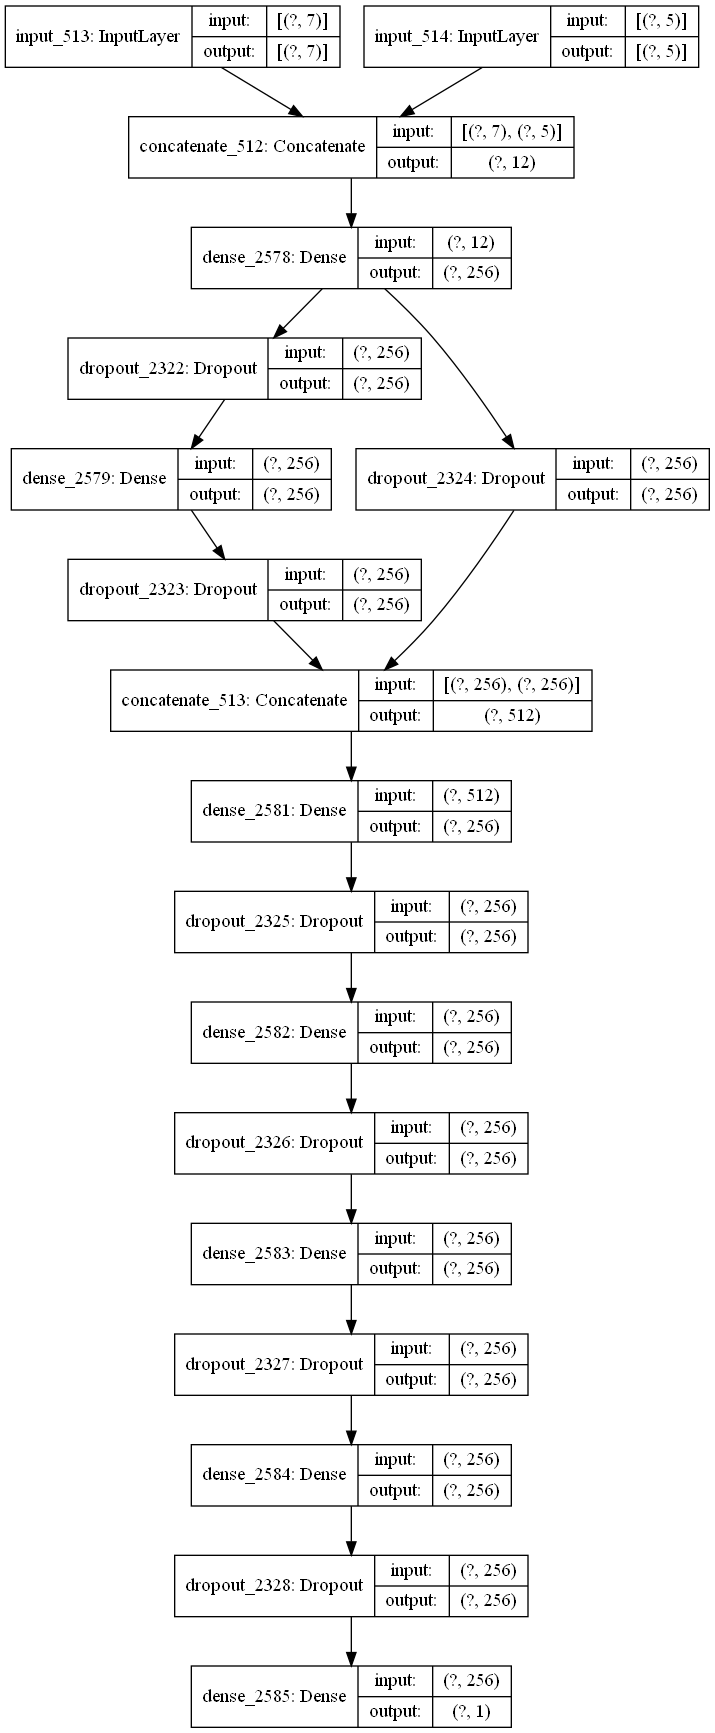

In [8]:
import os
os.mkdir("fraud_detector")

callbacks_list = [callbacks.EarlyStopping(monitor='val_loss', patience=1,), callbacks.ModelCheckpoint(filepath='fraud_detector.h5', monitor='val_loss', save_best_only=True,), callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,), callbacks.TensorBoard(log_dir="fraud_detector",histogram_freq=1,embeddings_freq=1,)]
num_branches, max_node_count, dropout, tail_length, kernel_regularization, bias_regularization = 0, 0, 0, 0, 0, 0
try:
    num_branches, max_node_count, dropout, tail_length, kernel_regularization, bias_regularization = best_params
except:
    num_branches, max_node_count, dropout, tail_length, kernel_regularization, bias_regularization = (4, 128, 0.4, 4, 0.05, 0.025)
combined_model = define_model(num_branches, max_node_count, dropout, tail_length, kernel_regularization, bias_regularization)
combined_model.compile(loss="binary_crossentropy")
print(combined_model.summary())
sample_data_non_transactional = np.array(sample_data_non_transactional)
sample_data_transactional = np.array(sample_data_transactional)
sample_data_transactional = sample_data_transactional.reshape((len(sample_data_non_transactional), 5))
sample_data_labels = np.array(sample_data_labels)
history = combined_model.fit(x=[sample_data_non_transactional, sample_data_transactional], y=sample_data_labels, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks_list)

plot_model(combined_model, to_file='fraud_detector.png', show_shapes=True)

#Calculate false positive and negative rates on whole data set

In [9]:
#make predictions based on ALL data rows (6362620 rows)
combined_model = load_model('fraud_detector.h5')
prediction = combined_model.predict([non_transaction_type_data, transaction_type_data], batch_size=128, verbose=1, use_multiprocessing=True)
prediction = prediction.reshape((6362620))
prediction = prediction.tolist()
truth_values = fraud_truth_value.reshape((6362620))
truth_values = truth_values.tolist()
#create counts for false pos, false negative, true pos, and true negative
false_pos_count = 0
false_negative_count = 0
true_pos_count = 0
true_negative_count = 0
#for each prediction
for idx in range(6362620):
    #compare each prediction to the true value
    #increment appropriate count
    if(abs(prediction[idx] - truth_values[idx]) < 0.5):
        if(int(truth_values[idx]) == 0):
            true_negative_count += 1
        else:
            true_pos_count += 1
    else:
        if(int(truth_values[idx]) == 0):
            false_pos_count += 1
        else:
            false_negative_count += 1
#output
print("True positives:", true_pos_count)
print("True negatives:", true_negative_count)
print("False positives:", false_pos_count)
print("False negatives:", false_negative_count)

49708/49708 [==============================] - 34s 684us/step
True positives: 0
True negatives: 6354407
False positives: 0
False negatives: 8213


#Evaluate network on test set

In [10]:
#use network.evaluate(test_set)
print(combined_model.evaluate([non_transaction_type_data, transaction_type_data], fraud_truth_value, verbose=0))
print(history.history)

0.6480686068534851
{'loss': [77679.796875, 7286.35107421875, 1110.3197021484375, 276.86260986328125, 87.9964828491211, 54.908226013183594, 27.89120864868164, 15.209228515625, 11.03148365020752, 6.6314473152160645, 2.9059078693389893, 1.3202530145645142, 0.904570460319519], 'val_loss': [2423.152099609375, 66.45726776123047, 64.66522979736328, 30.244861602783203, 20.82242202758789, 16.443960189819336, 12.743843078613281, 9.244803428649902, 6.5574140548706055, 4.212834358215332, 1.7754409313201904, 1.4843156337738037, 2.3998241424560547], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}
